# Clothes Recommendation System (DenseNet121)

Importing libraries

In [1]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

Bulding Clothes Recommendation System using DenseNet121

In [2]:
path = './fashion-dataset/'
dataset_path = pathlib.Path(path)
images=os.listdir(dataset_path)
images

['.DS_Store',
 'images.csv',
 'images',
 'fashion-dataset',
 'styles',
 'styles.csv']

Showing 10 images in dataset

In [11]:
#image dim
img_width, img_height, chnl = 200, 200, 3

# DenseNet121
densenet = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_width, img_height, chnl))
densenet.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    densenet,
    GlobalMaxPooling2D()
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 6, 6, 1024)        7037504   
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 1024)              0         
Total params: 7,037,504
Trainable params: 0
Non-trainable params: 7,037,504
_________________________________________________________________


Function of model prediction

In [12]:
def img_path(img):
    return path + 'images/' + img
def model_predict(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

Building data frame of model prediction for all our images from dataset (getting embedding for all items in dataset)

In [7]:
df_copy      = df
df_embedding = df_copy['image'].apply(lambda x: model_predict(model, x))
df_embedding        = df_embedding.apply(pd.Series)
df_embedding.head(5)

KeyboardInterrupt: 

Computing a cosine similarity to calculate a numeric quantity that denotes the similarity between two images. It is relatively easy and fast to calculate.

In [15]:
cosine_sim = linear_kernel(df_embedding, df_embedding)

Getting indices

In [16]:
indices = pd.Series(range(len(df)), index=df.index)

Getting recommendations using the cosine similarity

In [16]:
def get_recommendations(index, df, cosine_sim=cosine_sim):
    idx = indices[index]

    # Get the pairwsie similarity scores of all clothes with that one
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the clothes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 5 most similar clothes
    sim_scores = sim_scores[1:6]

    # Get the clothes indices
    cloth_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['image'].iloc[cloth_indices]

Checking the result 

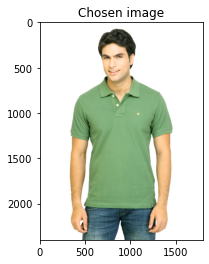

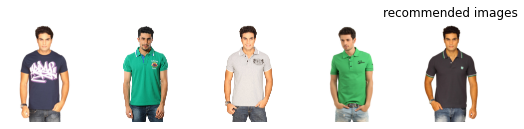

In [17]:
chosen_img_indx = 755

recommendation = get_recommendations(chosen_img_indx, df, cosine_sim)
recommendation_list = recommendation.to_list()
#chosen image
chosen_img =  mpimg.imread(path + 'images/' + df.iloc[chosen_img_indx].image)
plt.title("Chosen image")
plt.imshow(chosen_img)
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(path + 'images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("recommended images")
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

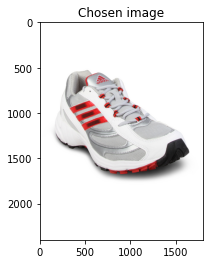

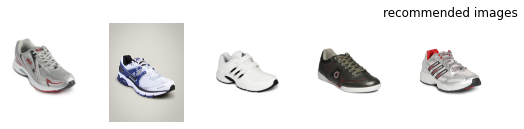

In [18]:
chosen_img_indx = 2501

recommendation = get_recommendations(chosen_img_indx, df, cosine_sim)
recommendation_list = recommendation.to_list()
#chosen image
chosen_img =  mpimg.imread(path + 'images/' + df.iloc[chosen_img_indx].image)
plt.title("Chosen image")
plt.imshow(chosen_img)
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(path + 'images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("recommended images")
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()